In [1]:
from matplotlib.pyplot import figure
from sklearn.metrics import f1_score
from scipy.sparse import csr_matrix
from numpy import count_nonzero
import matplotlib.pyplot as plt
from numpy import linalg as LA
import collections, numpy
from numpy import array
from time import time
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.io
import datetime
import random
import math

In [2]:
mushrooms = scipy.io.loadmat('C:\\Users\\Hunor\\Documents\\Moj Master rad\\Podaci za testiranje NKNKJTO\\Splice.mat')
train = pd.DataFrame(mushrooms['Xtrain'].toarray())

test = pd.DataFrame(mushrooms['Xtest'].toarray()) 

#labels = pd.DataFrame(mushrooms['ztrain'].toarray())
labels = pd.DataFrame(mushrooms['ztrain'])
labels = labels[0]
#labels = np.array(labels[0])

#labels_test = pd.DataFrame(mushrooms['ztest'].toarray())
labels_test = pd.DataFrame(mushrooms['ztest'])
labels_test = labels_test[0]
#labels_test = np.array(labels_test[0])

np.random.seed(11)
x0 = np.random.uniform(0,1,train.shape[1])

In [3]:
train.shape[1]

60

In [4]:
train.shape[0]+test.shape[0]

3175

In [5]:
def aimh(N_k):
    return (N_max-N_k)/N_max

In [7]:
def hinge_loss(x,N):
    prediction = train.iloc[:N,:].dot(x)
    maximums = np.maximum(0,1-labels[:N]*prediction)
    return l/2*LA.norm(x)**2+1/N*maximums.sum()

In [9]:
def hl_der(x,N):
    y=train.iloc[:N,:].dot(x)*labels[:N]
    maximumi= 1-y
    izvodi_svi = (train.iloc[:N,:].T*labels[:N]).T
    izvodi_veci = izvodi_svi[maximumi>0]
    izvodi_nula = izvodi_svi[maximumi==0]
    beta=np.random.uniform(0,1,np.size(izvodi_nula))
    if len(izvodi_nula)!=0:
        return np.array(l*x-izvodi_veci.sum()/N-np.dot(izvodi_nula,beta)/N)
    elif len(izvodi_nula)==0:
        return np.array(l*x-(izvodi_veci.sum())/N)

In [10]:
def new_sample(N_k): #working
    return math.ceil(N_max*(1-r*aimh(N_k)))

In [11]:
def merit_function(x_k, N_k, theta_k):
    return theta_k*hinge_loss(x_k, N_k)+(1-theta_k)*aimh(N_k)

In [12]:
def find_theta(x, N_tilda, N, theta):
    sum1 = merit_function(x, N_tilda, theta)-merit_function(x, N, theta)
    sum2 = (1-r)/2*(aimh(N_tilda)-aimh(N))
    if sum1 <= sum2:
        #print("Theta - Same")
        return theta
    else:
        sum3 = (1+r)*(aimh(N)-aimh(N_tilda))
        sum4 = hinge_loss(x, N_tilda)-hinge_loss(x, N)+aimh(N)-aimh(N_tilda)
        #print("Theta - Upgrade")
        return sum3/(2*sum4)

In [13]:
def model_Y(x, p, N, B):
    return np.matmul(np.matmul(p,np.linalg.inv(B)),p)/2 + sup_gp(x, p, N)

In [14]:
def sup_gp(x, p, N):
    sum1 = 0
    sum2 = 0
    for i in range(N):
        check = 1-labels[i]*np.matmul(train.iloc[i,:],x)
        if check == 0:
            inf = labels[i]*np.matmul(train.iloc[i,:],p)
            if inf < 0:
                sum1 += inf
        if check > 0:
            sum2 += labels[i]*train.iloc[i,:]
    return np.matmul(l*x - (sum2/N),p) - sum1/N

In [15]:
def argsup_gp(x, p, N): #working
    sum1 = np.zeros(x.shape)
    sum2 = np.zeros(x.shape)
    for i in range(N):
        check = 1-labels[i]*np.matmul(train.iloc[i,:],x) 
        if check > 0:
            sum1 += labels[i]*train.iloc[i][:]
        if check == 0:
            if labels[i]*np.matul(train.iloc[i,:],p) < 0:
                sum2 += lables[i]*train.iloc[i][:]           
    return np.array(l*x-sum1/N-sum2/N)

In [16]:
def descentDirection(g0_tilda, e, i_max, B, x, N): #working
    G_tilda = []
    G_bar = []
    P = []
    E = []
    
    #Step 0
    g0_bar = g0_tilda
    G_bar.append(g0_bar)
    G_tilda.append(g0_tilda)
    P.append(np.matmul(-B, G_tilda[0]))
    
    #Step 1
    G_tilda.append(argsup_gp(x, P[0], N))
        
    #Step 2
    E.append(np.matmul(P[0],G_tilda[1])-np.matmul(P[0],G_bar[0]))
    
    #Step 3
    i = 0
    while (np.matmul(G_tilda[i+1],P[i])>0 or E[0]>e) and E[i]>0 and i<i_max:
        first = np.matmul(G_bar[i]-G_tilda[i+1],np.matmul(B,G_bar[i]))
        second = np.matmul(G_bar[i]-G_tilda[i+1],np.matmul(B,G_bar[i]-G_tilda[i+1]))
        ni = min(1,first/second)
        G_bar.append((1-ni)*G_bar[i]+ni*G_tilda[i+1])
        P.append((1-ni)*P[i]-ni*np.matmul(B,G_tilda[i+1]))
        G_tilda.append(argsup_gp(x, P[i+1], N))
        e_list = []
        j = 0
        while j <= i+1:
            sum1 = np.matmul(P[j],G_tilda[j+1])
            sum2 = np.matmul(P[j],G_bar[j])+np.matmul(P[i+1],G_bar[i+1])
            e_list.append(sum1-sum2/2)
            j += 1
        E.append(min(e_list))
        i += 1
        
    #Step 4
    list_p = []
    j = 0
    while j <= i:
        list_p.append(model_Y(x, P[j], N, B))
        j += 1
    p_final = P[np.argmin(list_p)]
    
    #STEP5
    if sup_gp(x, p_final, N) < 0:
        #print("Iteration in finding P is %s" %i)
        return p_final
    else:
        print("!!! FAILED TO FIND DESCENT DIRECTION!!!")

In [17]:
def check1(x, alpha, p, N_trial, N_tilda):
    sum1 = hinge_loss(x+alpha*p, N_trial)
    sum2 = hinge_loss(x, N_tilda)
    sum3 = -gama*alpha*(LA.norm(p,2)**2)
    return (sum1-sum2)<=sum3

In [18]:
def check2(N_trial, N_tilda, alpha, p):
    sum1 = aimh(N_trial)
    sum2 = aimh(N_tilda)
    sum3 = gama_k*alpha*alpha*(LA.norm(p,2)**2)
    return sum1<=(sum2+sum3)

In [19]:
def check3(x, alpha, p, N_trial, theta, N_start, N_tilda):
    sum1 = merit_function(x+alpha*p, N_trial, theta)
    sum2 = merit_function(x, N_start, theta)
    sum3 = (1-r)*(aimh(N_tilda)-aimh(N_start))/2
    return (sum1-sum2)<=sum3

In [20]:
def BFGS(B, g_new, g_old, x_new, x_old):
    I = np.identity(g_new.size)
    y = g_new-g_old
    s = x_new-x_old
    sT = np.reshape(s,(1,-1)) # Dimension: 1xN
    s = np.reshape(s,(-1,1)) # Dimension: Nx1
    yT = np.reshape(y,(1,-1))
    y = np.reshape(y,(-1,1))
    ro = 1/(yT@s)
    sum1 = I-ro*(s@yT)
    sum2 = I-ro*(y@sT)
    sum3 = ro*(s@sT)
    return (np.matmul(np.matmul(sum1,B),sum2)+sum3)

In [21]:
def theta_k(theta):
    return N_max*theta/(1-theta)

In [22]:
def p_N_trial(N_start, N_tilda, theta, theta_k, alpha, p ,x):
    sum1 = N_start + ((1-r)/2)*(N_tilda-N_start)/(1-theta)
    sum2 = theta_k*(gama*alpha*(LA.norm(p,2)**2) - hinge_loss(x, N_tilda) + hinge_loss(x, N_start))
    return round(math.floor(sum1-sum2))
    #return sum1, sum2

In [23]:
def first_N_trial(N_start, N_tilda, theta, theta_k, alpha, x):
    sum1 = N_start+(1-r)/2*(N_tilda-N_start)/(1-theta)
    sum2 = theta_k*(gama*alpha-hinge_loss(x, N_tilda)+hinge_loss(x, N_start))
    return math.ceil(sum1-sum2)

In [24]:
def candidates(N_trial, N_tilda):
    storage = []
    storage.append(int(N_trial))
    storage.append(int(math.ceil((N_trial+N_tilda)/2)))
    storage.append(N_tilda)
    return storage

In [25]:
def scores(k, x):
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    correct = 0
    for i in range(test.shape[0]):
        value = np.matmul(test.iloc[i,:], x)
        if value > 0 and labels_test[i] > 0:
            true_pos += 1
        if value < 0 and labels_test[i] < 0:
            true_neg += + 1
        if value < 0 and labels_test[i] > 0:
            false_pos += + 1
        if value > 0 and labels_test[i] < 0:
            false_neg += + 1
        if value*labels_test[i]>0:
            correct += 1      
    F1 = round(true_pos/(true_pos + (false_pos+false_neg)/2),3)    
    Accuracy = round(correct / test.shape[0], 3)
    print("Iteration: %s | Accuracy: %s | F1: %s" %(k, F1, Accuracy))
    return F1, Accuracy

In [26]:
def backtracking_IRNS(B, x, N_trial, N_tilda, N_start, theta):
    alpha_start = 0.5
    degree = 0
    g0 = hl_der(x, N_trial[0])
    g1 = hl_der(x, N_trial[1])
    g2 = hl_der(x, N_trial[2])
    
    p0 = descentDirection(g0, e, i_max, B, x, N_trial[0])
    #print("P0 done")
    p1 = descentDirection(g1, e, i_max, B, x, N_trial[1])
    #print("P1 done")
    p2 = descentDirection(g2, e, i_max, B, x, N_trial[2])
    #print("P2 done")
    
    while True:
        alpha = alpha_start**degree
        
        first = check1(x, alpha, p0, N_trial[0], N_tilda)
        second = check2(N_trial[0], N_tilda, alpha, p0)
        third = check3(x, alpha, p0, N_trial[0], theta, N_start, N_tilda)
        if first and second and third:
            print("Alpha: %s | Trial value: %s" %(alpha,0))
            return alpha, p0, N_trial[0]
            break
        else:
            first = check1(x, alpha, p1, N_trial[1], N_tilda)
            second = check2(N_trial[1], N_tilda, alpha, p1) 
            third = check3(x, alpha, p1, N_trial[1], theta, N_start, N_tilda)
            if first and second and third:
                print("Alpha: %s | Trial value: %s" %(alpha,1))
                return alpha, p1, N_trial[1]
                break
            else:
                first = check1(x, alpha, p2, N_trial[2], N_tilda)
                second = check2(N_trial[2], N_tilda, alpha, p2) 
                third = check3(x, alpha, p2, N_trial[2], theta, N_start, N_tilda)
                if first and second and third:
                    print("Alpha: %s | Trial value: %s" %(alpha,2))
                    return alpha, p2, N_trial[2]
                    break
                else:
                    if degree >= 10:
                        print("forced to stop")
                        return alpha, p2, N_trial[2]
                        break
                    degree += 1
                    print(degree)

In [27]:
def backtracking_normal(B, x, N_trial, N_tilda, N_start, theta):
    alpha_start = 0.5
    degree = 0
    g = hl_der(x, N_trial)
    p = descentDirection(g,e,i_max,B,x,N_trial)
    while True:
        alpha = alpha_start**degree
        
        first = check1(x, alpha, p, N_trial, N_tilda)
        third = check3(x, alpha, p, N_trial, theta, N_start, N_tilda)
        #print(first, third)
        if first and third:
            #print("Alpha: %s" %alpha)
            return alpha, p
            break
        else:
            if degree >= 10:
                #print("forced to stop")
                return alpha, p
                break
            degree += 1
            #print(degree)

In [28]:
N_max = train.shape[0]
B0 = np.identity(x0.size)
gama = math.pow(10,-4)
e = math.pow(10,-4)
m = math.pow(10,-4)
theta0 = 0.9
i_max = 100
gama_k = 1
r = 0.95
l = math.pow(10,-5)

In [29]:
def algorithm(method): 
    start = time()
    
    max_fev = 0
    MAX_FEV = []
    MAX_FEV.append(max_fev)
    
    f_Ntrain = []
    N_tilda = []
    trial_N = []
    ITER = []
    ACC = []
    F1 = []
    T = []
    X = []
    P = []
    B = []
    G = []
    C = []
    A = []
    N = []
    
    X.append(x0)
    if method == "IRNS":
        N0 = math.ceil(0.1*N_max)
        N.append(N0)
        g0 = hl_der(x0, N[0])
        G.append(g0)
        max_fev += N[0]
        MAX_FEV.append(max_fev)
        f_Ntrain.append(hinge_loss(X[0],N_max))
         
    if method == "HEUR":
        N0 = math.ceil(0.1*N_max)
        N.append(N0)
        g0 = hl_der(x0, N[0])
        G.append(g0)
        max_fev += N[0]
        MAX_FEV.append(max_fev)
        f_Ntrain.append(hinge_loss(X[0],N_max))
        
    if method == "FSS":
        N0 = train.shape[0]
        N.append(N0)
        g0 = hl_der(X[0], N[0])
        G.append(g0)
        max_fev += N[0]
        MAX_FEV.append(max_fev)
        f_Ntrain.append(hinge_loss(X[0],N_max))
        
    N_tilda.append(0)
    T.append(theta0)
    B.append(B0)

    
    k = 0
    ITER.append(0)
    #while max_fev <= 10**5:
    while k <= 100:
        if method == "IRNS":
            N_tilda.append(new_sample(N[k]))
            T.append(find_theta(X[k], N_tilda[k+1], N[k], T[k]))
            
            #N_trial = round(0.8*N_tilda[-1])
            if k == 0:
                N_trial = first_N_trial(N[0], N_tilda[1], T[1], theta_k(T[1]), 1, X[0])
            else:
                N_trial = p_N_trial(N[k], N_tilda[k+1], T[k+1], theta_k(T[k+1]), A[-1], P[k-1] ,X[k])
            
            trial_N.append(N_trial)
            three_canditates = candidates(N_trial, N_tilda[k+1])
            C.append(three_canditates)
            print(C[k])
            alpha, p, N_new = backtracking_IRNS(B[k],X[k],three_canditates,N_tilda[k+1],N[k],T[k+1])
            N.append(N_new)
            max_fev += N[-1]
            MAX_FEV.append(max_fev)
            
        if method == "HEUR":
            N_tilda.append(new_sample(N[k]))
            T.append(find_theta(X[k], N_tilda[k+1], N[k], T[k]))
            N_trial = round(min(1.1*N[k],N_max))
            N.append(N_trial)
            alpha, p = backtracking_normal(B[k],X[k],N_trial,N_tilda[k+1],N[k],T[k+1])
            max_fev += N[-1]
            MAX_FEV.append(max_fev)
            
        if method == "FSS":
            N_tilda.append(train.shape[0])
            T.append(find_theta(X[k], N_tilda[k+1], N[k], T[k]))
            N_trial = train.shape[0]
            alpha, p = backtracking_normal(B[k], X[k], N_trial, N_tilda[k+1], N[k], T[k+1])
            N.append(train.shape[0])
            max_fev += N[-1]
            MAX_FEV.append(max_fev)

        P.append(p)
        A.append(alpha)

        #Step 4
        sk = alpha*P[k]
        X.append(X[k]+sk)
        f_Ntrain.append(hinge_loss(X[-1],N_max))
    

        F, Accuracy = scores(k, X[-1])
        F1.append(F)
        ACC.append(Accuracy)

        #print("Descent: %s | Semiposdef: %s " %(np.matmul(G[-1],P[-1])<0,np.all(np.linalg.eigvals(B[-1]) > 0)))

        #Step 5
        G.append(hl_der(X[k+1], N[k+1]))
        yk = G[k+1]-G[k]
        if np.matmul(sk,yk) >= m*LA.norm(yk,2)**2:
            B.append(BFGS(B[k], G[k+1], G[k], X[k+1], X[k]))
        else:
            B.append(B[k])

        #Step 6
        k += 1 
        ITER.append(k)
        print("-------------------------------------")
    end = time()
    b = end - start
    print(' ')
    print('Time elapsed: %s minutes and %s seconds.'%(np.floor(b / 60), np.round(b % 60)))
    return F1, ACC, MAX_FEV, f_Ntrain, N, ITER

In [30]:
F1_IRNS, ACC_IRNS, MAX_FEV_IRNS, f_Ntrain_IRNS, N_IRNS, ITER_IRNS = algorithm("IRNS")

[369, 369, 369]
1
Alpha: 0.5 | Trial value: 0
Iteration: 0 | Accuracy: 0.0 | F1: 0.469
-------------------------------------
[388, 433, 478]
Alpha: 1.0 | Trial value: 0
Iteration: 1 | Accuracy: 0.693 | F1: 0.531
-------------------------------------
[361, 429, 496]
Alpha: 1.0 | Trial value: 0
Iteration: 2 | Accuracy: 0.573 | F1: 0.643
-------------------------------------
[365, 418, 470]
1
Alpha: 0.5 | Trial value: 0
Iteration: 3 | Accuracy: 0.723 | F1: 0.654
-------------------------------------
[370, 422, 474]
Alpha: 1.0 | Trial value: 0
Iteration: 4 | Accuracy: 0.757 | F1: 0.748
-------------------------------------
[376, 428, 479]
Alpha: 1.0 | Trial value: 0
Iteration: 5 | Accuracy: 0.79 | F1: 0.798
-------------------------------------
[383, 434, 485]
Alpha: 1.0 | Trial value: 0
Iteration: 6 | Accuracy: 0.816 | F1: 0.813
-------------------------------------
[389, 440, 491]
Alpha: 1.0 | Trial value: 0
Iteration: 7 | Accuracy: 0.835 | F1: 0.82
-------------------------------------


Alpha: 1.0 | Trial value: 2
Iteration: 64 | Accuracy: 0.859 | F1: 0.85
-------------------------------------
[2312, 2318, 2324]
Alpha: 1.0 | Trial value: 2
Iteration: 65 | Accuracy: 0.858 | F1: 0.849
-------------------------------------
[2324, 2330, 2335]
Alpha: 1.0 | Trial value: 2
Iteration: 66 | Accuracy: 0.86 | F1: 0.852
-------------------------------------
[2335, 2341, 2346]
Alpha: 1.0 | Trial value: 2
Iteration: 67 | Accuracy: 0.86 | F1: 0.852
-------------------------------------
[2346, 2351, 2356]
Alpha: 1.0 | Trial value: 2
Iteration: 68 | Accuracy: 0.859 | F1: 0.85
-------------------------------------
[2356, 2361, 2366]
Alpha: 1.0 | Trial value: 2
Iteration: 69 | Accuracy: 0.858 | F1: 0.85
-------------------------------------
[2366, 2371, 2375]
Alpha: 1.0 | Trial value: 2
Iteration: 70 | Accuracy: 0.861 | F1: 0.854
-------------------------------------
[2375, 2380, 2384]
Alpha: 1.0 | Trial value: 2
Iteration: 71 | Accuracy: 0.86 | F1: 0.852
-------------------------------

In [31]:
F1_HEUR, ACC_HEUR, MAX_FEV_HEUR, f_Ntrain_HEUR, N_HEUR, ITER_HEUR = algorithm("HEUR")

Iteration: 0 | Accuracy: 0.0 | F1: 0.469
-------------------------------------
Iteration: 1 | Accuracy: 0.631 | F1: 0.589
-------------------------------------
Iteration: 2 | Accuracy: 0.582 | F1: 0.628
-------------------------------------
Iteration: 3 | Accuracy: 0.786 | F1: 0.787
-------------------------------------
Iteration: 4 | Accuracy: 0.815 | F1: 0.809
-------------------------------------
Iteration: 5 | Accuracy: 0.816 | F1: 0.802
-------------------------------------
Iteration: 6 | Accuracy: 0.816 | F1: 0.806
-------------------------------------
Iteration: 7 | Accuracy: 0.83 | F1: 0.827
-------------------------------------
Iteration: 8 | Accuracy: 0.831 | F1: 0.824
-------------------------------------
Iteration: 9 | Accuracy: 0.84 | F1: 0.831
-------------------------------------
Iteration: 10 | Accuracy: 0.841 | F1: 0.833
-------------------------------------
Iteration: 11 | Accuracy: 0.848 | F1: 0.843
-------------------------------------
Iteration: 12 | Accuracy: 0.85

In [32]:
F1_FSS, ACC_FSS, MAX_FEV_FSS, f_Ntrain_FSS, N_FSS, ITER_FSS = algorithm("FSS")

Iteration: 0 | Accuracy: 0.0 | F1: 0.469
-------------------------------------
Iteration: 1 | Accuracy: 0.693 | F1: 0.531
-------------------------------------
Iteration: 2 | Accuracy: 0.681 | F1: 0.647
-------------------------------------
Iteration: 3 | Accuracy: 0.639 | F1: 0.669
-------------------------------------
Iteration: 4 | Accuracy: 0.761 | F1: 0.759
-------------------------------------
Iteration: 5 | Accuracy: 0.855 | F1: 0.843
-------------------------------------
Iteration: 6 | Accuracy: 0.857 | F1: 0.846
-------------------------------------
Iteration: 7 | Accuracy: 0.861 | F1: 0.854
-------------------------------------
Iteration: 8 | Accuracy: 0.869 | F1: 0.861
-------------------------------------
Iteration: 9 | Accuracy: 0.864 | F1: 0.857
-------------------------------------
Iteration: 10 | Accuracy: 0.864 | F1: 0.857
-------------------------------------
Iteration: 11 | Accuracy: 0.864 | F1: 0.858
-------------------------------------
Iteration: 12 | Accuracy: 0.

### Graphics

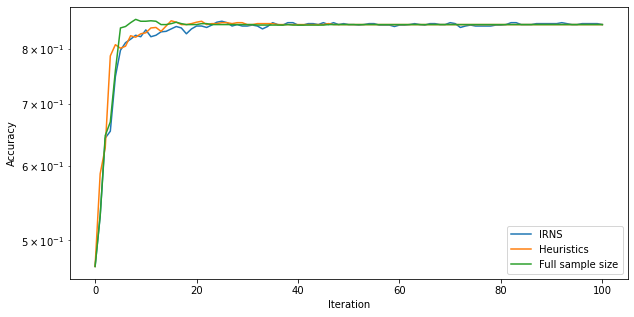

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(ACC_IRNS)
plt.plot(ACC_HEUR)
plt.plot(ACC_FSS)
plt.legend(["IRNS", "Heuristics","Full sample size"], loc ="lower right")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.yscale("log")
plt.show()

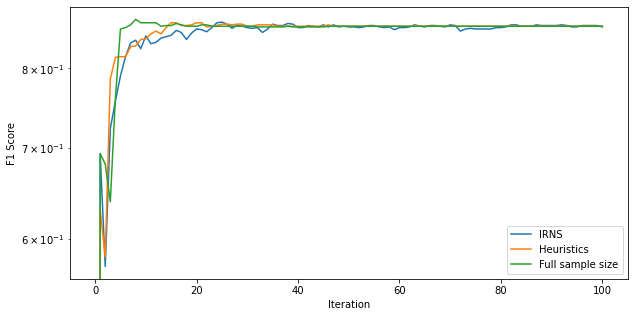

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(F1_IRNS)
plt.plot(F1_HEUR)
plt.plot(F1_FSS)
plt.legend(["IRNS", "Heuristics","Full sample size"], loc ="lower right")
plt.xlabel("Iteration")
plt.ylabel("F1 Score")
plt.yscale("log")
plt.show()

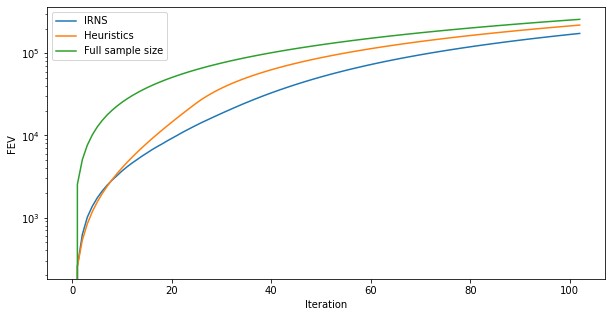

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(MAX_FEV_IRNS)
plt.plot(MAX_FEV_HEUR)
plt.plot(MAX_FEV_FSS)
plt.legend(["IRNS", "Heuristics","Full sample size"], loc ="upper left")
plt.xlabel("Iteration")
plt.ylabel("FEV")
plt.yscale("log")
plt.show()

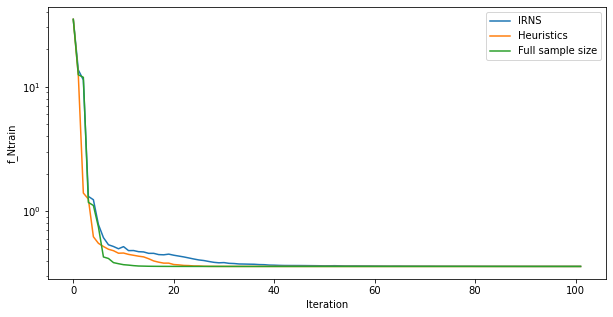

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(f_Ntrain_IRNS)
plt.plot(f_Ntrain_HEUR)
plt.plot(f_Ntrain_FSS)
plt.legend(["IRNS", "Heuristics","Full sample size"], loc ="upper right")
plt.xlabel("Iteration")
plt.ylabel("f_Ntrain")
plt.yscale("log")
plt.show()

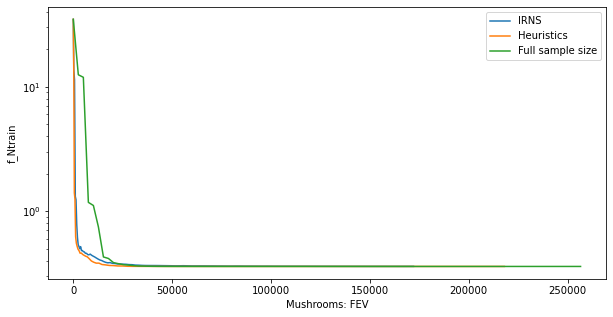

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(MAX_FEV_IRNS[:-1],f_Ntrain_IRNS)
plt.plot(MAX_FEV_HEUR[:-1],f_Ntrain_HEUR)
plt.plot(MAX_FEV_FSS[:-1],f_Ntrain_FSS)
plt.legend(["IRNS", "Heuristics","Full sample size"], loc ="upper right")
plt.xlabel("Mushrooms: FEV")
plt.ylabel("f_Ntrain")
plt.yscale("log")
plt.show()

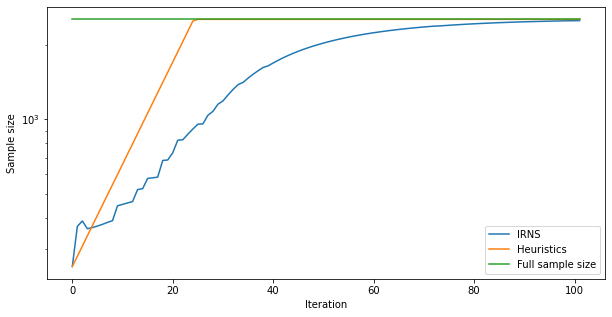

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(N_IRNS)
plt.plot(N_HEUR)
plt.plot(N_FSS)
plt.legend(["IRNS", "Heuristics","Full sample size"], loc ="lower right")
plt.xlabel("Iteration")
plt.ylabel("Sample size")
plt.yscale("log")
plt.show()